## *Outlier Detection Using Unsupervised Machine Learning*, 


# -- START: Techical Requirements --

You can install PyOD with either `pip` or `conda`. 

* For a pip install, run the following command:

```
pip install pyod
```


* For a `conda` install, run the following command:

```
conda install -c conda-forge pyod
```

In [2]:
import matplotlib 
import pandas as pd
import pyod 
import statsmodels

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
''')


Matplotlib -> 3.10.7
pandas -> 2.3.3   



In [3]:
from pyod import version
version.__version__

'2.0.5'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


plt.rcParams["figure.figsize"] = [12, 5]

### Create DataFrames 

In [6]:
file = Path("data/nyc_taxi.csv")
nyc_taxi = pd.read_csv(file, 
                     index_col='timestamp', 
                     parse_dates=True)
nyc_taxi.index.freq = '30min'

In [7]:
def plot_outliers(outliers, data, method='KNN', halignment='right', valignment='bottom', labels=False):
    """
    Plot time series data with highlighted outliers.
    
    Parameters
    ----------
    outliers : pandas.DataFrame or pandas.Series
        The DataFrame or Series containing the outlier data points.
    data : pandas.DataFrame or pandas.Series
        The complete time series data.
    method : str, default='KNN'
        The outlier detection method used, displayed in the plot title.
    halignment : str, default='right'
        Horizontal alignment for the date labels ('left', 'center', or 'right').
    valignment : str, default='bottom'
        Vertical alignment for the date labels ('top', 'center', or 'bottom').
    labels : bool, default=False
        If True, displays date labels for each outlier point.
        
    Returns
    -------
    None
        The function shows the plot but does not return any value.
    """
    
    fig, ax = plt.subplots(figsize=(10, 6))
        
    data.plot(ax=ax, alpha=0.6)
    
    # Plot outliers
    if labels:
        outliers.plot(ax=ax, style='rx', markersize=8, legend=False)
        
        # Add text labels for each outlier
        for idx, value in outliers['value'].items():
            ax.text(idx, value, f'{idx.date()}', 
                   horizontalalignment=halignment, 
                   verticalalignment=valignment)
    else:
        outliers.plot(ax=ax, style='rx', legend=False)
    
    ax.set_title(f'NYC Taxi - {method}')
    ax.set_xlabel('date')
    ax.set_ylabel('# of passengers')
    ax.legend(['nyc taxi', 'outliers'])
    
    plt.tight_layout()
    plt.show()


### Visualize DataFrames

In [8]:
nyc_taxi.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq='30min')

In [9]:
nyc_dates =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]
tx = nyc_taxi.resample('D').mean()
known_outliers = tx.loc[nyc_dates]

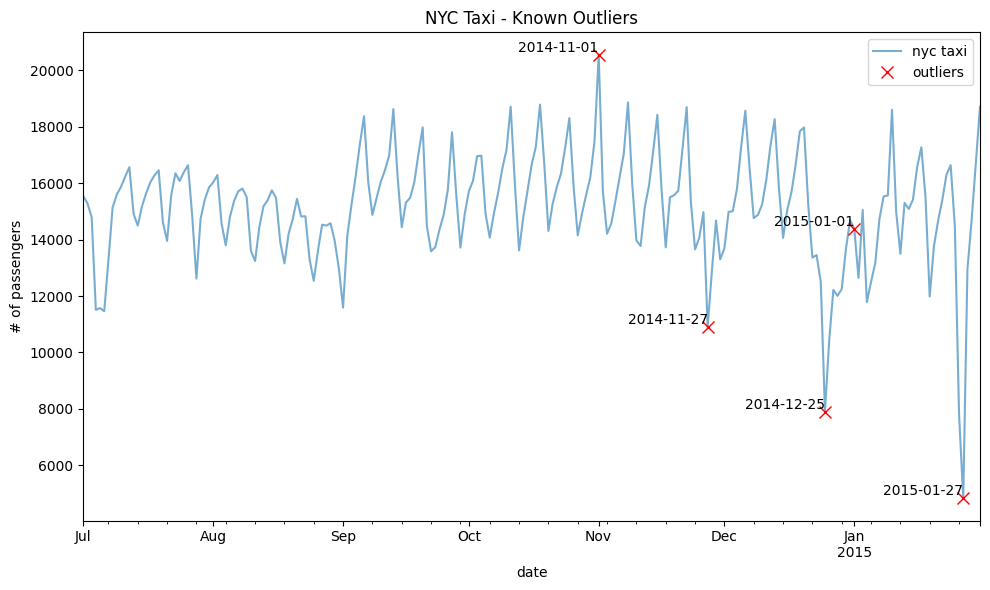

In [10]:
plot_outliers(known_outliers, tx, 'Known Outliers', labels=True)

In [11]:
def create_sliding_windows(df, window_size):
    """Transform time series data into sliding windows for anomaly detection.
    
    Creates a DataFrame where each row represents a sliding window of observations,
    allowing anomaly detection algorithms to identify unusual temporal patterns.
    
    Args:
        df (pd.DataFrame): Univariate time series data with values in a single column
        window_size (int): Number of time steps in each sliding window
        
    Returns:
        pd.DataFrame: DataFrame where each row is a complete window of observations,
                     and columns represent the position within the window
    """
    # Validate input
    if not isinstance(window_size, int) or window_size < 1:
        raise ValueError("Window size must be a positive integer")
    
    # Convert DataFrame to 1D array
    d = df.values.squeeze()
    
    # Create sliding windows using numpy's efficient implementation
    windows = np.lib.stride_tricks.sliding_window_view(d, window_shape=window_size)[:-1]
    
    # Create column names for positions within the window
    cols = [f'pos_{i}' for i in range(window_size)]
    
    # Create DataFrame with windows
    windows_df = pd.DataFrame(windows, columns=cols, index=df.index[window_size:])
    
    return windows_df

In [13]:
import holidays

def add_time_features(df):
    """Add time-based and exogenous features to a daily time series dataset.
    
    Creates features useful for time series anomaly detection by encoding 
    temporal patterns and external factors that might influence the data.
    
    Args:
        df (pd.DataFrame): Time series DataFrame with DatetimeIndex
        
    Returns:
        pd.DataFrame: Original DataFrame with additional time-based features
    """
    # Create a copy to avoid modifying the original
    result = df.copy()
    
    # Cyclical encoding for day of week (weekly seasonality)
    result['dow_sin'] = np.sin(2 * np.pi * result.index.dayofweek / 7)
    result['dow_cos'] = np.cos(2 * np.pi * result.index.dayofweek / 7)
    
    # Cyclical encoding for month (yearly seasonality)
    result['month_sin'] = np.sin(2 * np.pi * result.index.month / 12)
    result['month_cos'] = np.cos(2 * np.pi * result.index.month / 12)
    
    # Keep year for trend analysis
    result['year'] = result.index.year
    
    # Trend feature (simple incremental counter)
    result['time'] = np.arange(1, len(result)+1)
    
    # US holidays - fix the datetime comparison warning
    us_holidays = holidays.US(years=result.index.year.unique())
    result['is_holiday'] = result.index.map(lambda x: x in us_holidays).astype(int)
    
    # Weekend feature
    result['is_weekend'] = (result.index.dayofweek >= 5).astype(int)
    
    # Month start/end features (can be important for taxi data)
    result['is_month_start'] = result.index.is_month_start.astype(int)
    result['is_month_end'] = result.index.is_month_end.astype(int)
    
    # For NYC taxi data: check if it's a typical commuting day
    result['is_commuting_day'] = ((~result['is_holiday'].astype(bool)) & 
                                 (~result['is_weekend'].astype(bool))).astype(int)
    
    return result

In [14]:
create_sliding_windows(tx, 2)

,pos_0,pos_1
timestamp,,
2014-07-03,15540.979167,15284.166667
2014-07-04,15284.166667,14794.625000
2014-07-05,14794.625000,11511.770833
2014-07-06,11511.770833,11572.291667
2014-07-07,11572.291667,11464.270833
...,...,...
2015-01-27,14463.791667,7818.979167
2015-01-28,7818.979167,4834.541667
2015-01-29,4834.541667,12947.562500


In [15]:
add_time_features(tx)

,value,dow_sin,dow_cos,month_sin,month_cos,year,time,is_holiday,is_weekend,is_month_start,is_month_end,is_commuting_day
timestamp,,,,,,,,,,,,
2014-07-01,15540.979167,0.781831,0.623490,-0.5,-0.866025,2014,1,0,0,1,0,1
2014-07-02,15284.166667,0.974928,-0.222521,-0.5,-0.866025,2014,2,0,0,0,0,1
2014-07-03,14794.625000,0.433884,-0.900969,-0.5,-0.866025,2014,3,0,0,0,0,1
2014-07-04,11511.770833,-0.433884,-0.900969,-0.5,-0.866025,2014,4,1,0,0,0,0
2014-07-05,11572.291667,-0.974928,-0.222521,-0.5,-0.866025,2014,5,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-27,4834.541667,0.781831,0.623490,0.5,0.866025,2015,211,0,0,0,0,1
2015-01-28,12947.562500,0.974928,-0.222521,0.5,0.866025,2015,212,0,0,0,0,1
2015-01-29,14686.145833,0.433884,-0.900969,0.5,0.866025,2015,213,0,0,0,0,1


# Detecting outliers using statistical & distance-based algorithms (PyOD)

In [16]:
from pyod.models.knn import KNN
from pyod.models.lof import LOF

## Detecting Point Outliers

In [17]:
knn = KNN(contamination=0.03,
          method='mean',
          n_neighbors=5)
print(knn)

KNN(algorithm='auto', contamination=0.03, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)


In [18]:
lof = LOF(contamination=0.03, 
          n_neighbors=20) 
print(lof)

LOF(algorithm='auto', contamination=0.03, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2)


In [19]:
knn.fit(tx)
lof.fit(tx)

LOF(algorithm='auto', contamination=0.03, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2)

In [21]:
knn_pred = pd.Series(knn.predict(tx), 
                      index=tx.index)

lof_pred = pd.Series(lof.predict(tx), 
                      index=tx.index)

In [22]:
print('Number of KNN outliers = ', knn_pred.sum())
print('Number of LOF outliers = ', lof_pred.sum())

Number of KNN outliers =  6
Number of LOF outliers =  6


In [23]:
# known outliers dates
print(tx.loc[nyc_dates])

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-01  14383.479167
2015-01-27   4834.541667


In [24]:
# extract the outlier values and dates from knn_pred
knn_outliers = knn_pred[knn_pred == 1]
knn_outliers = tx.loc[knn_outliers.index] 
print(knn_outliers)

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


In [25]:
# extract the outlier values and dates from lof_pred
lof_outliers = lof_pred[lof_pred == 1]
lof_outliers = tx.loc[lof_outliers.index] 
print(lof_outliers)

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


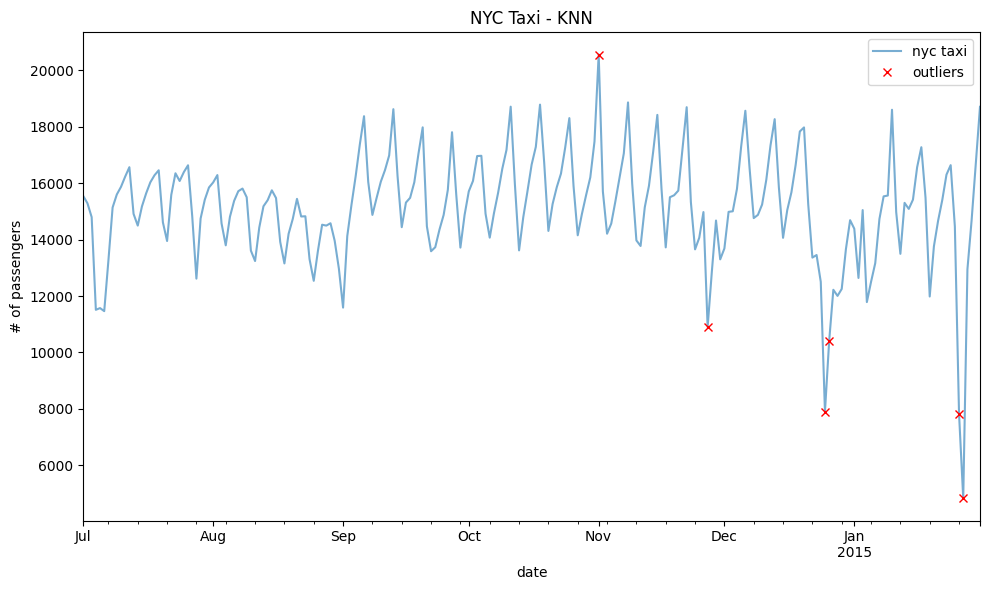

In [26]:
plot_outliers(knn_outliers, tx, 'KNN')

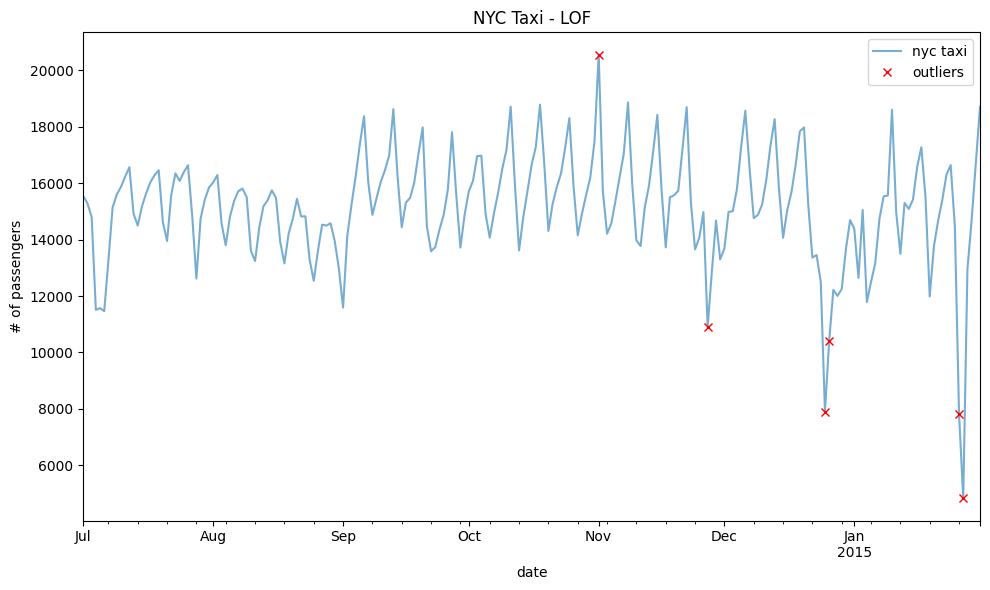

In [27]:
plot_outliers(lof_outliers, tx, 'LOF')

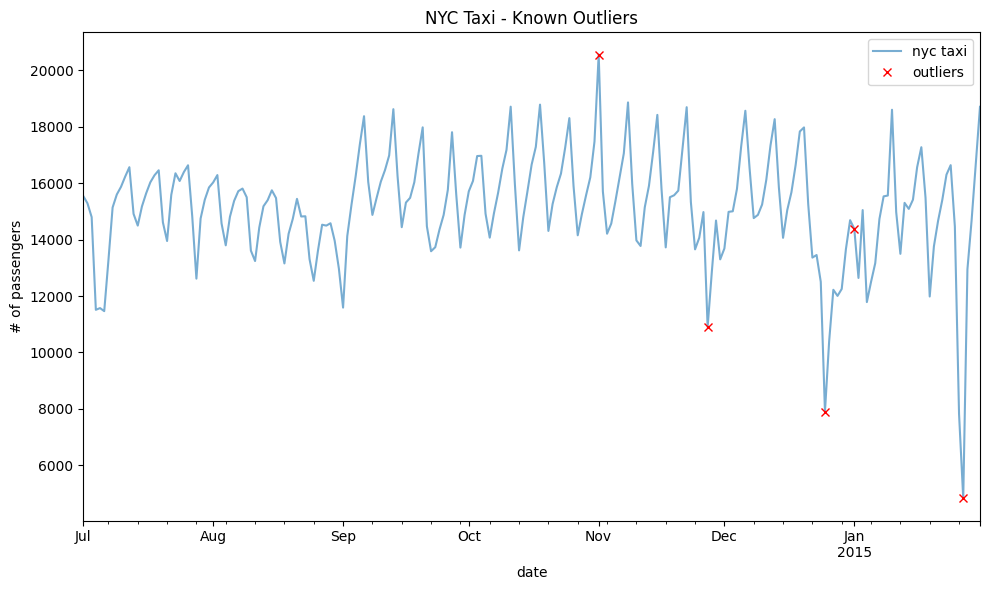

In [28]:
plot_outliers(known_outliers, tx, 'Known Outliers')

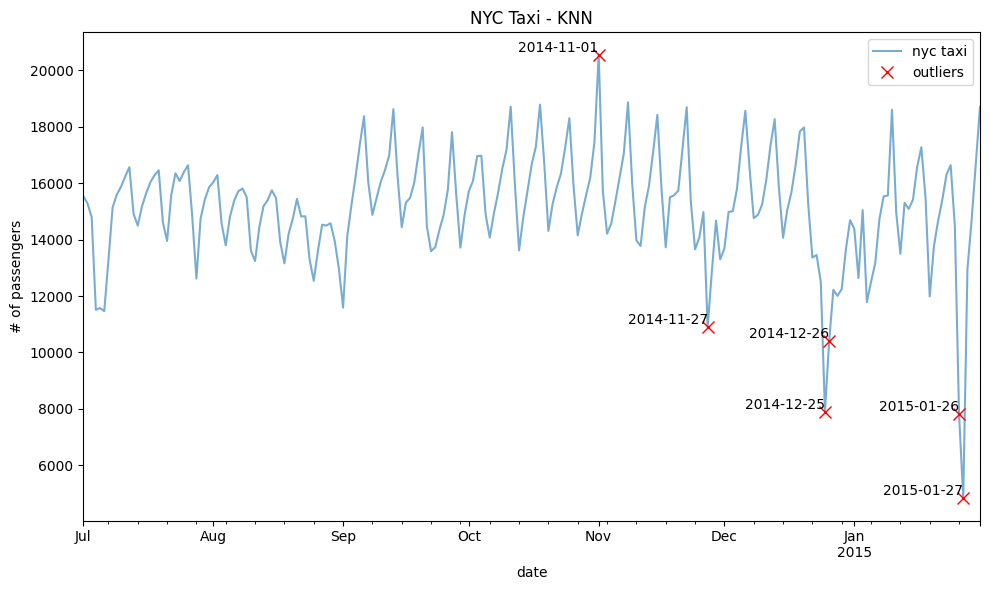

In [29]:
plot_outliers(knn_outliers, 
              tx, 
              'KNN',
              labels=True)

## Detecting Outliers after Decomposition

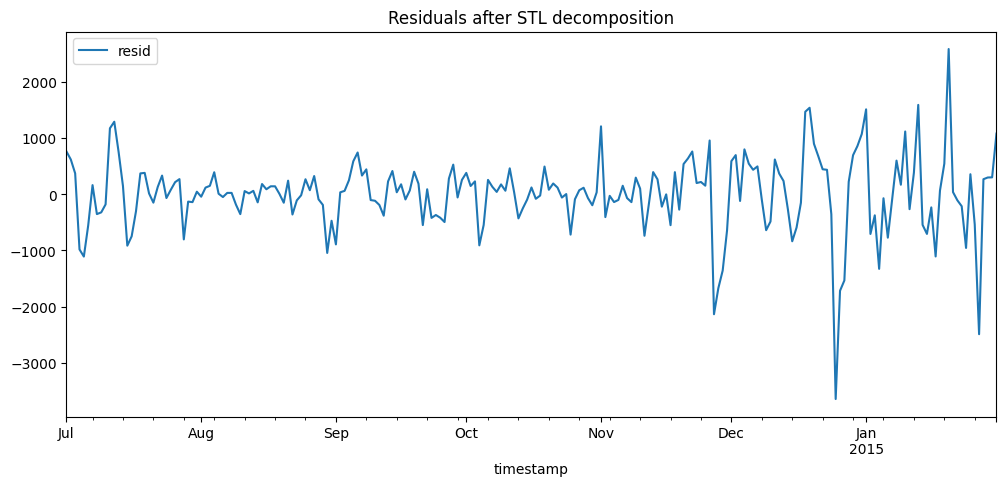

In [30]:
from statsmodels.tsa.seasonal import STL

# For daily data with weekly seasonality
stl = STL(tx, seasonal=7)
result = stl.fit()
residuals = result.resid.dropna().to_frame()

residuals.plot(title='Residuals after STL decomposition');




In [31]:
knn_decomp = KNN(contamination=0.03,
          method='mean',
          n_neighbors=5)
lof_decomp = LOF(contamination=0.03, 
          n_neighbors=20) 

# Apply PyOD to residuals
knn_r = knn_decomp.fit(residuals)
lof_r = lof_decomp.fit(residuals)

knn_pred_r = pd.Series(knn_decomp.predict(residuals), 
                      index=residuals.index)

lof_pred_r = pd.Series(lof_decomp.predict(residuals), 
                      index=residuals.index)

In [32]:
print('Number of KNN outliers after Decomposition = ', knn_pred_r.sum())
print('Number of LOF outliers  after Decomposition = ', lof_pred_r.sum())

Number of KNN outliers after Decomposition =  4
Number of LOF outliers  after Decomposition =  4


In [33]:
print(known_outliers)

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-01  14383.479167
2015-01-27   4834.541667


In [34]:
# extract the outlier values and dates from knn_pred_r
knn_outliers_r = knn_pred_r[knn_pred_r == 1]
knn_outliers_r = tx.loc[knn_outliers_r.index] 
print(knn_outliers_r)

                   value
timestamp               
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-20  13759.416667
2015-01-27   4834.541667


In [35]:
# extract the outlier values and dates from lof_pred_r
lof_outliers_r = lof_pred_r[lof_pred_r == 1]
lof_outliers_r = tx.loc[lof_outliers_r.index] 
print(lof_outliers_r)

                   value
timestamp               
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-20  13759.416667
2015-01-27   4834.541667


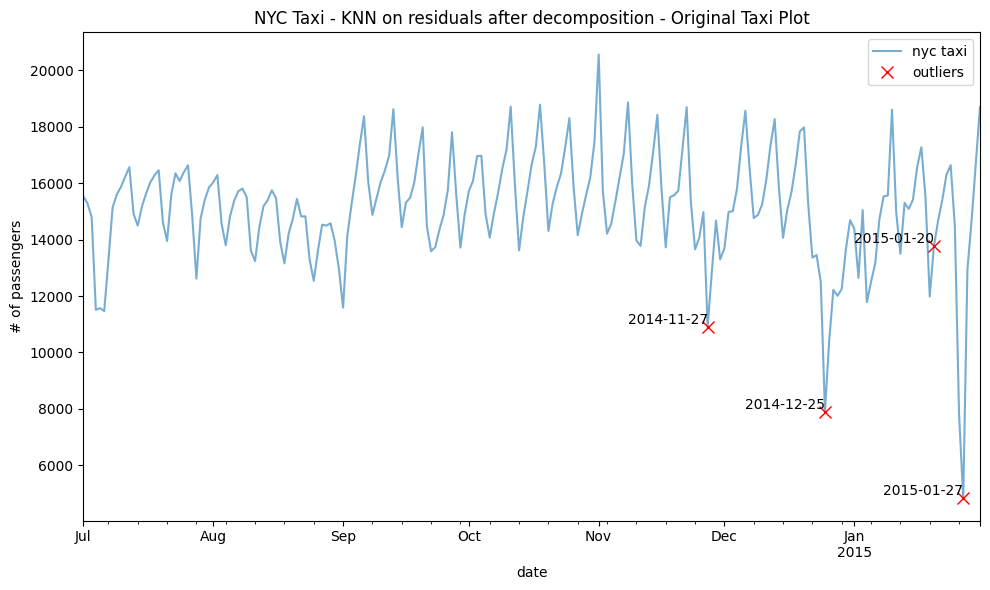

In [36]:
plot_outliers(knn_outliers_r, tx, 'KNN on residuals after decomposition - Original Taxi Plot', labels=True)

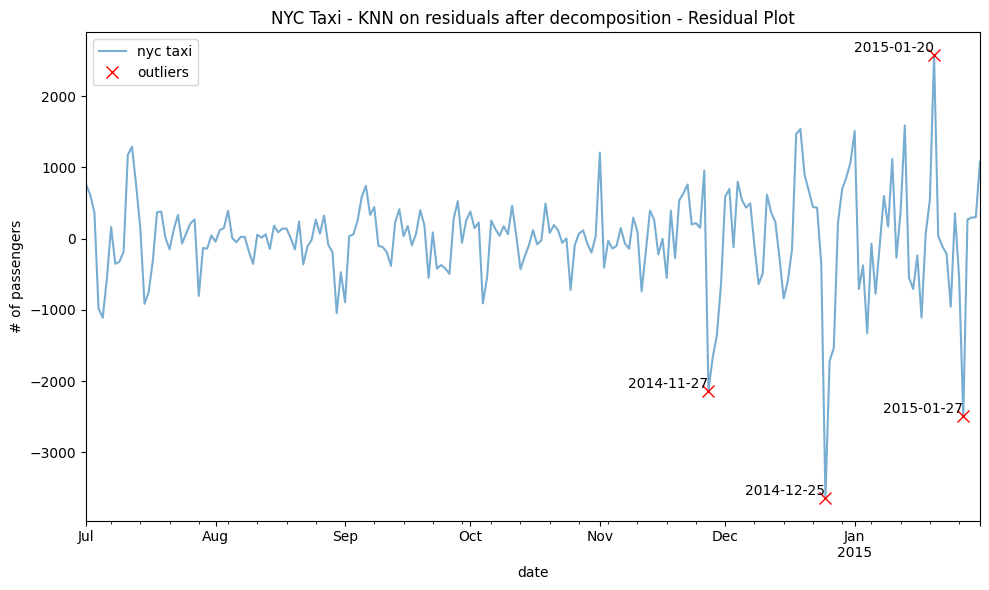

In [37]:
res = residuals[knn_pred_r == 1]
res.columns = ['value']
plot_outliers(res, residuals, 'KNN on residuals after decomposition - Residual Plot', labels=True)

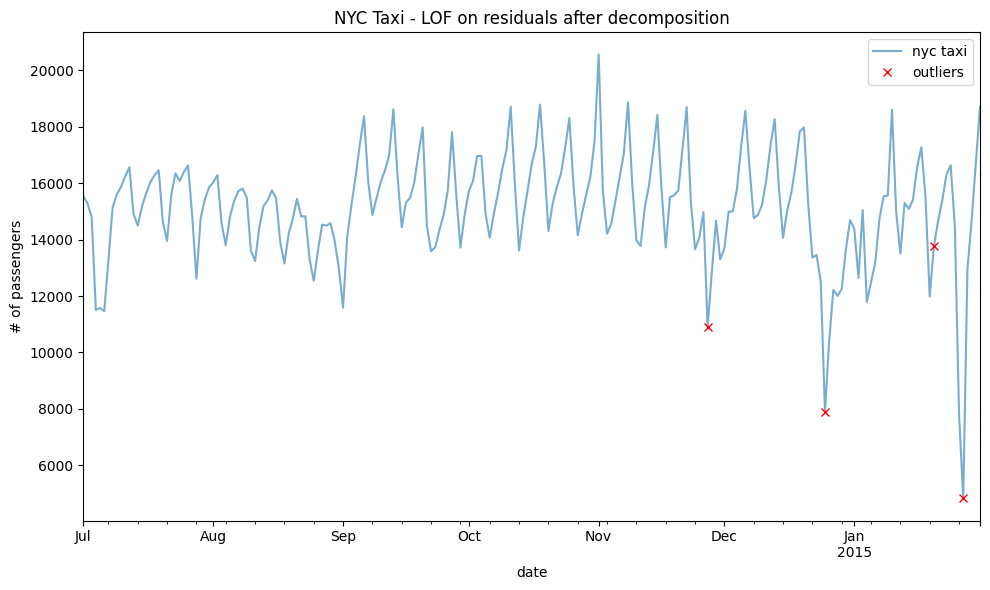

In [38]:
plot_outliers(lof_outliers_r, tx, 'LOF on residuals after decomposition')

## Detecting Contextual Outliers with Sliding Window

In [39]:
def create_sliding_windows(df, window_size):
    """Transform time series data into sliding windows for anomaly detection.
    
    Creates a DataFrame where each row represents a sliding window of observations,
    allowing anomaly detection algorithms to identify unusual temporal patterns.
    
    Args:
        df (pd.DataFrame): Univariate time series data with values in a single column
        window_size (int): Number of time steps in each sliding window
        
    Returns:
        pd.DataFrame: DataFrame where each row is a complete window of observations,
                     and columns represent the position within the window
    """
    # Validate input
    if not isinstance(window_size, int) or window_size < 1:
        raise ValueError("Window size must be a positive integer")
    
    # Convert DataFrame to 1D array
    d = df.values.squeeze()
    
    # Create sliding windows using numpy's efficient implementation
    windows = np.lib.stride_tricks.sliding_window_view(d, window_shape=window_size)[:-1]
    
    # Create column names for positions within the window
    cols = [f'pos_{i}' for i in range(window_size)]
    
    # Create DataFrame with windows
    windows_df = pd.DataFrame(windows, columns=cols, index=df.index[window_size:])
    
    return windows_df


In [40]:
tx_sw = create_sliding_windows(tx, window_size=7)
print(tx_sw.shape)

(208, 7)


In [41]:
knn_sw = KNN(contamination=0.03,
          method='mean',
          n_neighbors=5)

lof_sw = LOF(contamination=0.03, 
          n_neighbors=20)


knn_sw.fit(tx_sw)
lof_sw.fit(tx_sw)

knn_pred_sw = pd.Series(knn_sw.predict(tx_sw), 
                      index=tx_sw.index)

lof_pred_sw = pd.Series(lof_sw.predict(tx_sw), 
                      index=tx_sw.index)

print('Number of KNN outliers = ', knn_pred_sw.sum())
print('Number of LOF outliers = ', lof_pred_sw.sum())


Number of KNN outliers =  4
Number of LOF outliers =  6


In [42]:
# known outliers dates
print(tx.loc[nyc_dates])

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-01  14383.479167
2015-01-27   4834.541667


In [43]:
knn_pred_sw

timestamp
2014-07-08    0
2014-07-09    0
2014-07-10    0
2014-07-11    0
2014-07-12    0
             ..
2015-01-27    0
2015-01-28    1
2015-01-29    1
2015-01-30    1
2015-01-31    1
Freq: D, Length: 208, dtype: int64

In [44]:
# extract the outlier values and dates from knn_pred_sw
knn_outliers_sw = knn_pred_sw[knn_pred_sw == 1]
knn_outliers_sw = tx.loc[knn_outliers_sw.index] 
print(knn_outliers_sw)


                   value
timestamp               
2015-01-28  12947.562500
2015-01-29  14686.145833
2015-01-30  16676.625000
2015-01-31  18702.479167


In [45]:
# extract the outlier values and dates from lof_pred_sw
lof_outliers_sw = lof_pred_sw[lof_pred_sw == 1]
lof_outliers_sw = tx.loc[lof_outliers_sw.index] 
print(lof_outliers_sw)


                   value
timestamp               
2014-12-26  10397.958333
2015-01-27   4834.541667
2015-01-28  12947.562500
2015-01-29  14686.145833
2015-01-30  16676.625000
2015-01-31  18702.479167


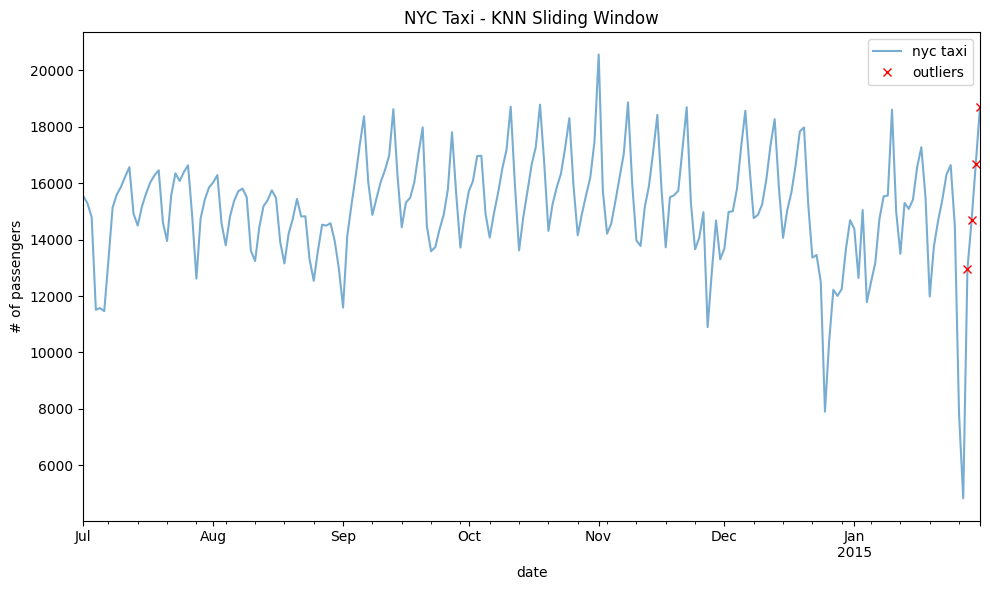

In [46]:
plot_outliers(knn_outliers_sw, tx, 'KNN Sliding Window')

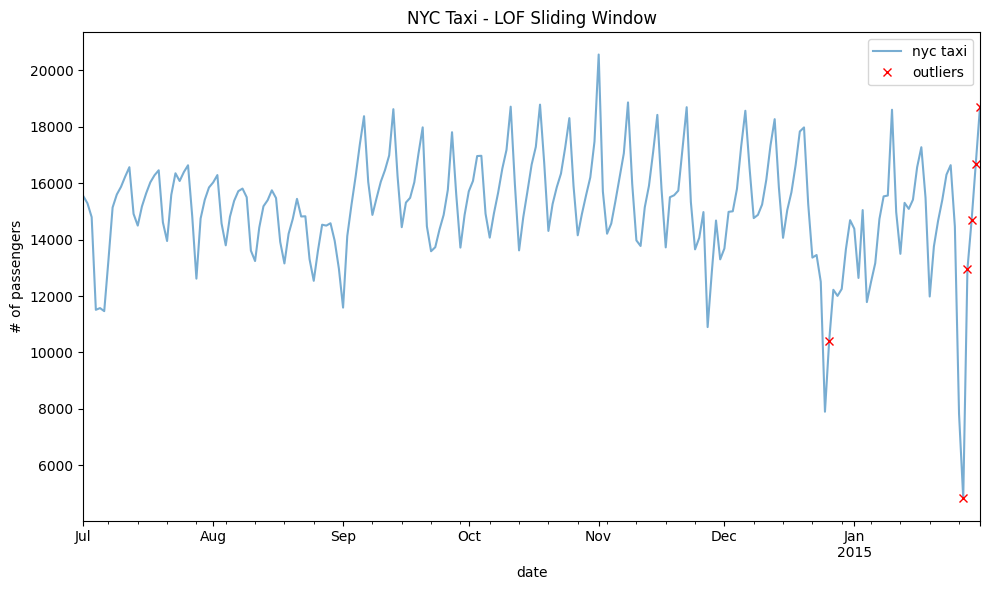

In [47]:
plot_outliers(lof_outliers_sw, tx, 'LOF Sliding Window')

## Detecting Contextual Outliers with Feature Engineering

In [48]:
import holidays

def add_time_features(df):
    """Add time-based and exogenous features to a daily time series dataset.
    
    Creates features useful for time series anomaly detection by encoding 
    temporal patterns and external factors that might influence the data.
    
    Args:
        df (pd.DataFrame): Time series DataFrame with DatetimeIndex
        
    Returns:
        pd.DataFrame: Original DataFrame with additional time-based features
    """
    # Create a copy to avoid modifying the original
    result = df.copy()
    
    # Cyclical encoding for day of week (weekly seasonality)
    result['dow_sin'] = np.sin(2 * np.pi * result.index.dayofweek / 7)
    result['dow_cos'] = np.cos(2 * np.pi * result.index.dayofweek / 7)
    
    # Cyclical encoding for month (yearly seasonality)
    result['month_sin'] = np.sin(2 * np.pi * result.index.month / 12)
    result['month_cos'] = np.cos(2 * np.pi * result.index.month / 12)
    
    # Keep year for trend analysis
    result['year'] = result.index.year
    
    # Trend feature (simple incremental counter)
    result['time'] = np.arange(1, len(result)+1)
    
    # US holidays - fix the datetime comparison warning
    us_holidays = holidays.US(years=result.index.year.unique())
    result['is_holiday'] = result.index.map(lambda x: x in us_holidays).astype(int)
    
    # Weekend feature
    result['is_weekend'] = (result.index.dayofweek >= 5).astype(int)
    
    # Month start/end features (can be important for taxi data)
    result['is_month_start'] = result.index.is_month_start.astype(int)
    result['is_month_end'] = result.index.is_month_end.astype(int)
    
    # For NYC taxi data: check if it's a typical commuting day
    result['is_commuting_day'] = ((~result['is_holiday'].astype(bool)) & 
                                 (~result['is_weekend'].astype(bool))).astype(int)
    
    return result 


In [49]:
# combine with sliding windows for more context
windows = create_sliding_windows(tx, 7)
features = add_time_features(tx)
# Join the windows with the features at the corresponding dates
combined = pd.merge(
    windows, 
    features.drop(columns=['value']),  # Exclude the target value
    left_index=True, 
    right_index=True
)

print(combined.shape)

(208, 18)


In [50]:
knn_fe = KNN(contamination=0.03,
          method='mean',
          n_neighbors=5)

lof_fe = LOF(contamination=0.03, 
          n_neighbors=20)


knn_fe.fit(combined)
lof_fe.fit(combined)

knn_pred_fe = pd.Series(knn_fe.predict(combined), 
                      index=combined.index)

lof_pred_fe = pd.Series(lof_fe.predict(combined), 
                      index=combined.index)

# extract the outlier values and dates from knn_pred_fe
knn_outliers_fe = knn_pred_fe[knn_pred_fe == 1]
knn_outliers_fe = tx.loc[knn_outliers_fe.index] 
print(knn_outliers_fe)

                   value
timestamp               
2015-01-28  12947.562500
2015-01-29  14686.145833
2015-01-30  16676.625000
2015-01-31  18702.479167


In [51]:
# extract the outlier values and dates from lof_pred_fe
lof_outliers_fe = lof_pred_fe[lof_pred_fe == 1]
lof_outliers_fe = tx.loc[lof_outliers_fe.index] 
print(lof_outliers_fe)

                   value
timestamp               
2014-12-26  10397.958333
2015-01-27   4834.541667
2015-01-28  12947.562500
2015-01-29  14686.145833
2015-01-30  16676.625000
2015-01-31  18702.479167


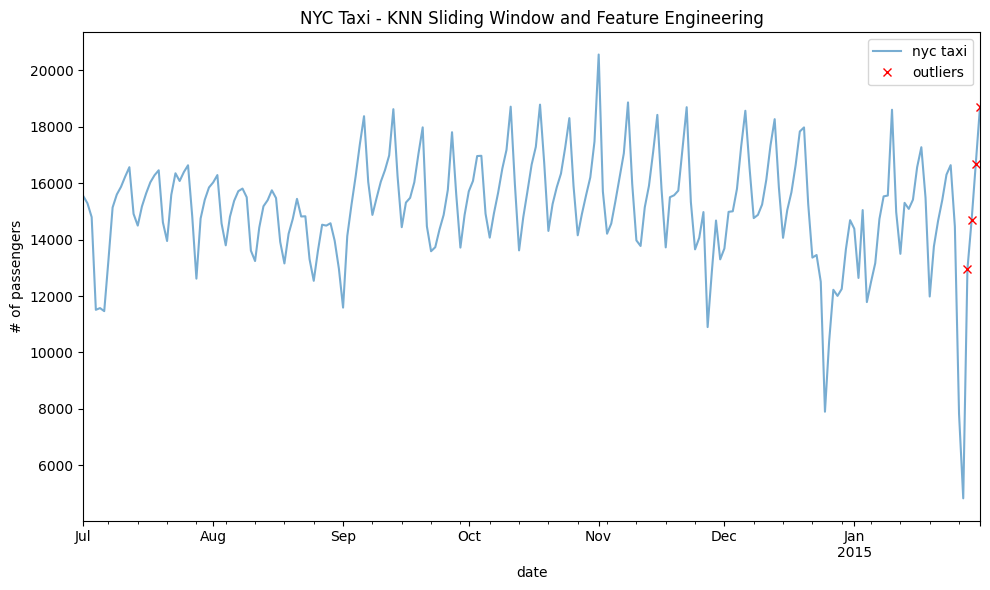

In [52]:
plot_outliers(knn_outliers_fe, tx, 'KNN Sliding Window and Feature Engineering')

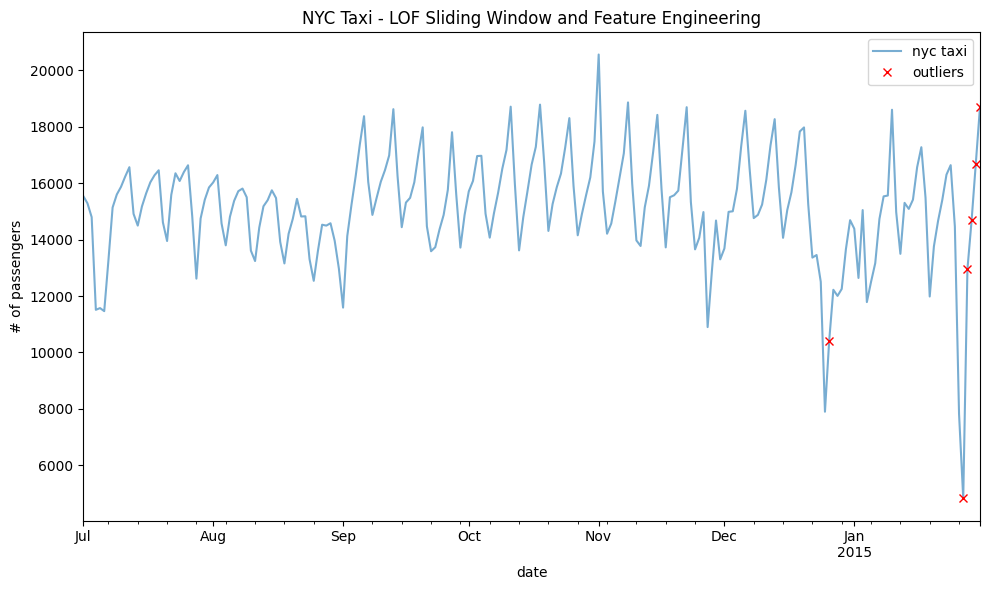

In [53]:
plot_outliers(lof_outliers_fe, tx, 'LOF Sliding Window and Feature Engineering')

## How it works

In [55]:
knn = KNN(contamination=0.03,
          method='mean',
          n_neighbors=5)

knn.fit(tx)

KNN(algorithm='auto', contamination=0.03, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [56]:
knn_scores = knn.decision_scores_

In [57]:
knn_scores_df = (pd.DataFrame(knn_scores, 
             index=tx.index, 
             columns=['score']))

knn_scores_df.quantile(0.97)

score    225.017917
Name: 0.97, dtype: float64

In [58]:
knn_scores = knn.decision_function(tx)
knn_scores_df = (pd.DataFrame(knn_scores, 
             index=tx.index, 
             columns=['score']))
knn_scores_df.quantile(0.97)

score    161.19375
Name: 0.97, dtype: float64

In [59]:
knn.threshold_

np.float64(225.0179166666657)

In [60]:
print(knn_scores_df[knn_scores_df['score'] > knn.threshold_])

                  score
timestamp              
2014-11-01  1433.762500
2014-11-27   470.208333
2014-12-25  1728.820833
2014-12-26   771.233333
2015-01-26  1745.450000
2015-01-27  3536.112500


In [61]:
n = int(len(tx)*0.03)
print(knn_scores_df.nlargest(n, 'score').sort_index())

                  score
timestamp              
2014-11-01  1433.762500
2014-11-27   470.208333
2014-12-25  1728.820833
2014-12-26   771.233333
2015-01-26  1745.450000
2015-01-27  3536.112500


In [62]:
knn_scores_df.min()

score    7.425
dtype: float64

In [63]:
knn_scores_df.max()

score    3536.1125
dtype: float64

In [64]:
(2474.508333 - 11.745833)*100/(4862.058333-11.745833)

50.77533664068037

In [65]:
knn_proba = knn.predict_proba(tx, method='linear')
knn_proba_df = (pd.DataFrame(np.round(knn_proba * 100, 3),
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly']))
print(knn_proba_df.nlargest(n, 'Proba_Anomaly'))

            Proba_Normal  Proba_Anomaly
timestamp                              
2015-01-27        27.337         72.663
2015-01-26        64.256         35.744
2014-12-25        64.599         35.401
2014-11-01        70.682         29.318
2014-12-26        84.341         15.659
2014-11-27        90.548          9.452


In [66]:
knn_proba = knn.predict_proba(tx, method='unify')
knn_proba_df = (pd.DataFrame(np.round(knn_proba * 100, 3),
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly']))
print(knn_proba_df.nlargest(n, 'Proba_Anomaly').sort_index())

            Proba_Normal  Proba_Anomaly
timestamp                              
2014-11-01         0.189         99.811
2014-11-27        40.330         59.670
2014-12-25         0.014         99.986
2014-12-26        12.225         87.775
2015-01-26         0.012         99.988
2015-01-27         0.000        100.000


In [67]:
knn_conf = knn.predict_confidence(tx)
knn_conf_df = (pd.DataFrame(knn_conf,
            index=tx.index,
            columns=['confidence']))
print(knn_conf_df.nsmallest(n, 'confidence').sort_index())

            confidence
timestamp             
2014-11-01    0.624149
2014-11-27    0.304893
2014-12-25    0.624149
2014-12-26    0.452453
2015-01-26    0.624149
2015-01-27    0.984580


In [68]:
from joblib import dump, load

# save the model
dump(knn, 'knn_outliers.joblib')
# load the model
knn = load('knn_outliers.joblib')

In [69]:
knn

KNN(algorithm='auto', contamination=0.03, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

## There is more

In [70]:
def knn_explore(df, method='mean', contamination=0.03, k=5):
    
    m = KNN(contamination=contamination,
              method=method,
              n_neighbors=k)
    m.fit(df)
    
    decision_score = pd.DataFrame(m.decision_scores_, 
                          index=df.index, columns=['score'])
    n = int(len(df)*contamination)
    outliers = decision_score.nlargest(n, 'score')
    return outliers, m.threshold_

In [71]:
for method in ['mean', 'median', 'largest']:
    o, t = knn_explore(tx, method=method, contamination=0.05)
    print(f'Method= {method}, Threshold= {t}')
    print(o)

Method= mean, Threshold= 220.32916666666603
                  score
timestamp              
2015-01-27  4862.058333
2015-01-26  2474.508333
2014-12-25  2441.250000
2014-11-01  1806.850000
2014-12-26  1009.616667
2014-11-27   608.250000
2014-09-27   225.604167
2014-07-06   224.208333
2014-12-28   223.562500
2015-01-19   223.562500
Method= median, Threshold= 211.64999999999995
                  score
timestamp              
2015-01-27  5563.416667
2014-12-25  2997.541667
2015-01-26  2984.437500
2014-11-01  1847.083333
2014-12-26  1113.812500
2014-11-27   612.104167
2014-12-29   251.520833
2014-12-27   238.062500
2015-01-19   238.062500
2014-12-28   219.145833
Method= largest, Threshold= 411.85624999999993
                  score
timestamp              
2015-01-27  6629.729167
2015-01-26  3645.291667
2014-12-25  3562.145833
2014-11-01  1865.437500
2014-12-26  1191.916667
2014-11-27   690.208333
2014-07-06   518.583333
2014-07-04   471.083333
2014-12-19   436.604167
2014-09-27   431.750000

# Detecting outliers using clustering-based algorithms (PyOD)

In [73]:
from pyod.models.cblof import CBLOF

In [74]:
cblof = CBLOF(n_clusters=8, 
              contamination=0.03,
              alpha=0.9,
              beta=5)
cblof

CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.03, n_clusters=8, n_jobs=None, random_state=None,
   use_weights=False)

In [75]:
cblof.fit(tx)
cblof_pred = pd.Series(cblof.predict(tx), 
                      index=tx.index)
print('Number of CBLOF outliers = ', cblof_pred.sum())

Number of CBLOF outliers =  7


In [76]:
# extract the outlier values and dates from cblof_pred
cblof_outliers = cblof_pred[cblof_pred == 1]
cblof_outliers = tx.loc[cblof_outliers.index] 
print(cblof_outliers)


                   value
timestamp               
2014-07-06  11464.270833
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


In [77]:
print(known_outliers)

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-01  14383.479167
2015-01-27   4834.541667


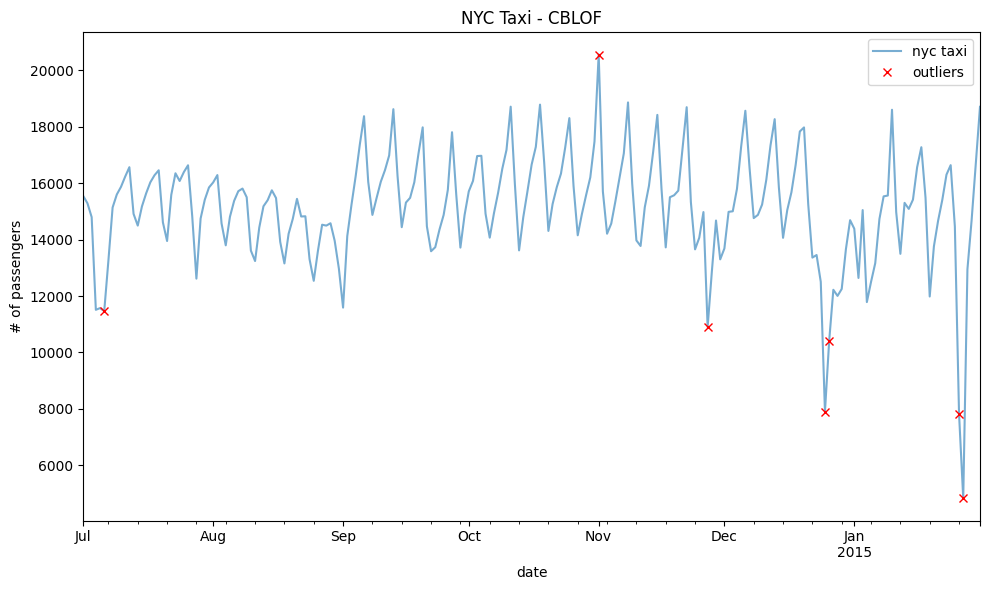

In [78]:
plot_outliers(cblof_outliers, tx, 'CBLOF')

In [79]:
from pyod.utils import evaluate_print
# Create binary ground truth labels (1 for known outliers, 0 for normal points)
y = tx.index.isin(known_outliers.index).astype(int)
evaluate_print('CBLOF', y, cblof.decision_scores_)

CBLOF ROC:0.9733, precision @ rank n:0.6


# Detecting outliers using probabilistic and statistical algorithms

In [82]:
from pyod.models.copod import COPOD

In [83]:
copod = COPOD(contamination=0.03)
copod.fit(tx)

COPOD(contamination=0.03, n_jobs=1)

In [84]:
copod_pred = pd.Series(copod.predict(tx), 
                      index=tx.index)

In [85]:
print('Number of COPOD outliers = ', copod_pred.sum())

Number of COPOD outliers =  7


In [86]:
# extract the outlier values and dates from copod_pred
copod_outliers = copod_pred[copod_pred == 1]
copod_outliers = tx.loc[copod_outliers.index]
print(copod_outliers)

                   value
timestamp               
2014-07-04  11511.770833
2014-07-06  11464.270833
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


In [87]:
known_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


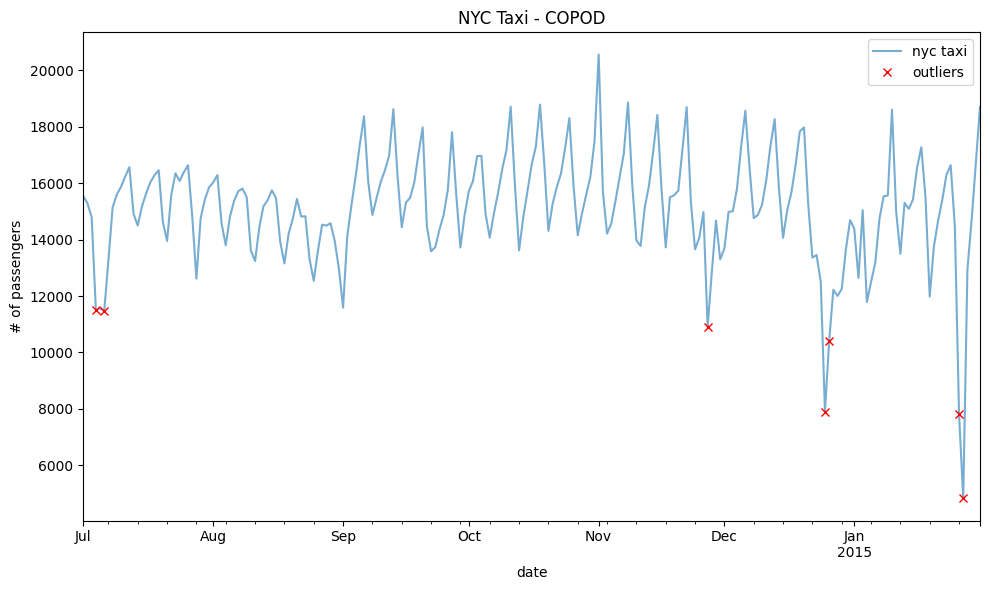

In [88]:
plot_outliers(copod_outliers, tx, 'COPOD')

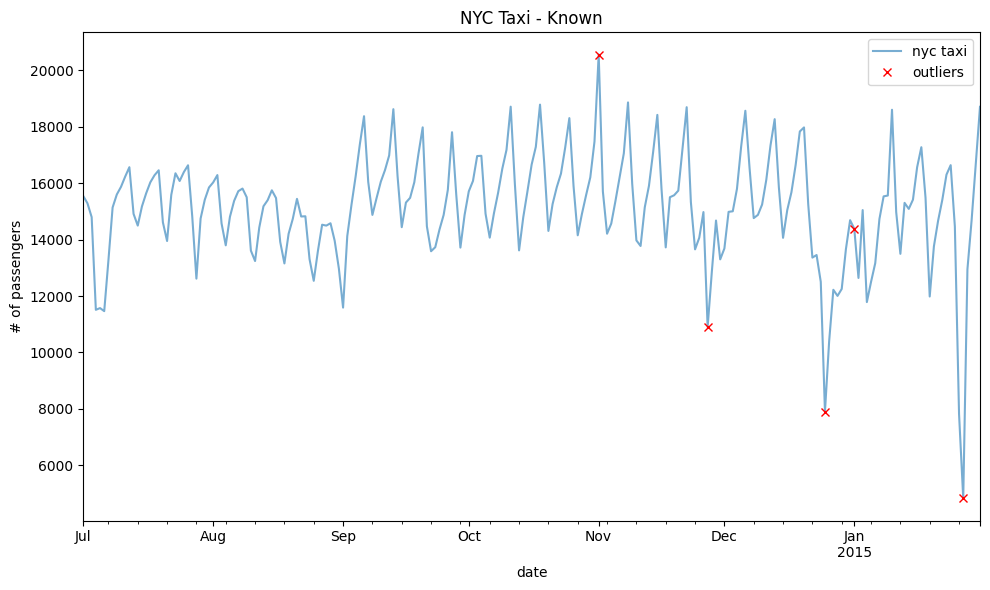

In [89]:
plot_outliers(known_outliers, tx, 'Known')

## There is more

In [90]:
from pyod.models.ecod import ECOD

# Initialize and fit the ECOD model
ecod = ECOD(contamination=0.03)
ecod.fit(tx)

# Predict outliers
ecod_pred = pd.Series(ecod.predict(tx), 
                     index=tx.index)
print('Number of ECOD outliers = ', ecod_pred.sum())

# extract the outlier values and dates from ecod_pred
ecod_outliers = ecod_pred[ecod_pred == 1]
ecod_outliers = tx.loc[ecod_outliers.index]
print(ecod_outliers)

Number of ECOD outliers =  6
                   value
timestamp               
2014-10-18  18778.958333
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-12-25   7902.125000
2015-01-26   7818.979167
2015-01-27   4834.541667


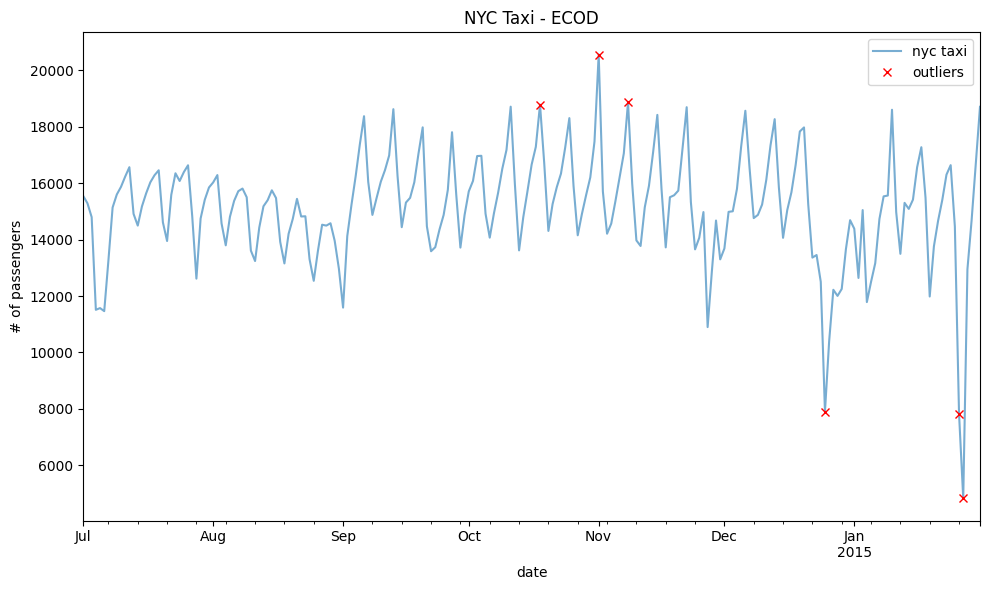

In [91]:
plot_outliers(ecod_outliers, tx, 'ECOD')

# Detecting outliers using kernel-based algorithms (PyOD)

In [92]:
from pyod.models.ocsvm import OCSVM

In [93]:
ocsvm = OCSVM(contamination=0.03, 
              kernel='rbf',
              gamma='auto',
              nu=0.5)
ocsvm.fit(tx)

OCSVM(cache_size=200, coef0=0.0, contamination=0.03, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)

In [94]:
ocsvm_pred = pd.Series(ocsvm.predict(tx), 
                      index=tx.index)

/Users/tarekatwan/Repos/MyWork/Teach/repos/advanced_machine_learning/dev1/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


In [95]:
print('Number of OCSVM outliers = ', ocsvm_pred.sum())

Number of OCSVM outliers =  5


In [96]:
# extract the outlier values and dates from ocsvm_pred
ocsvm_outliers = ocsvm_pred[ocsvm_pred == 1]
ocsvm_outliers = tx.loc[ocsvm_outliers.index] 
print(ocsvm_outliers)

                   value
timestamp               
2014-08-09  15499.708333
2014-11-18  15499.437500
2014-11-27  10899.666667
2014-12-24  12502.000000
2015-01-05  12502.750000


In [97]:
print(known_outliers)

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-01  14383.479167
2015-01-27   4834.541667


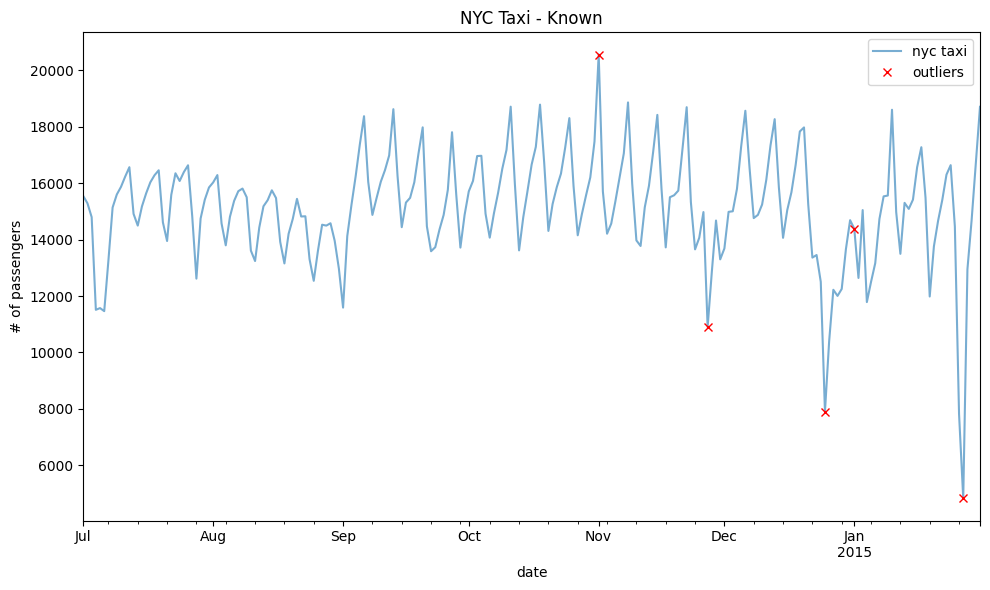

In [98]:
plot_outliers(known_outliers, tx, 'Known')

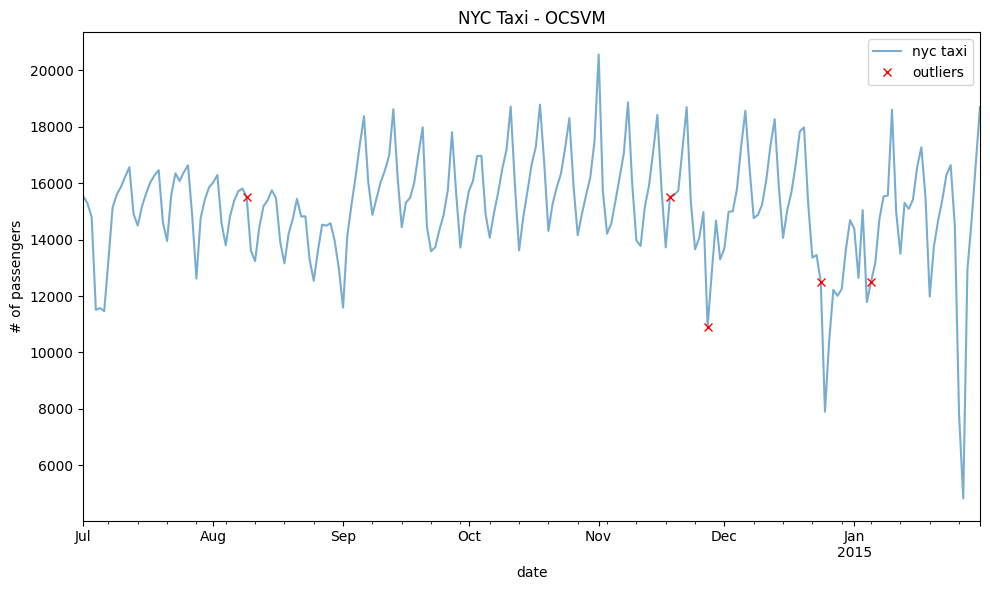

In [99]:
plot_outliers(ocsvm_outliers, tx, 'OCSVM')

In [100]:
from pyod.utils.utility import standardizer

ocsvm = OCSVM(contamination=0.03, 
              kernel='rbf',
              gamma='auto',
              nu=0.5)

scaled = standardizer(tx)
ocsvm.fit(scaled)
ocsvm_pred_sc = pd.Series(ocsvm.predict(scaled), 
                      index=tx.index)

# extract the outlier values and dates from ocsvm_pred_sc
ocsvm_outliers_sc = ocsvm_pred_sc[ocsvm_pred_sc == 1]
ocsvm_outliers_sc = tx.loc[ocsvm_outliers_sc.index] 
print(ocsvm_outliers_sc)

                   value
timestamp               
2014-07-06  11464.270833
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


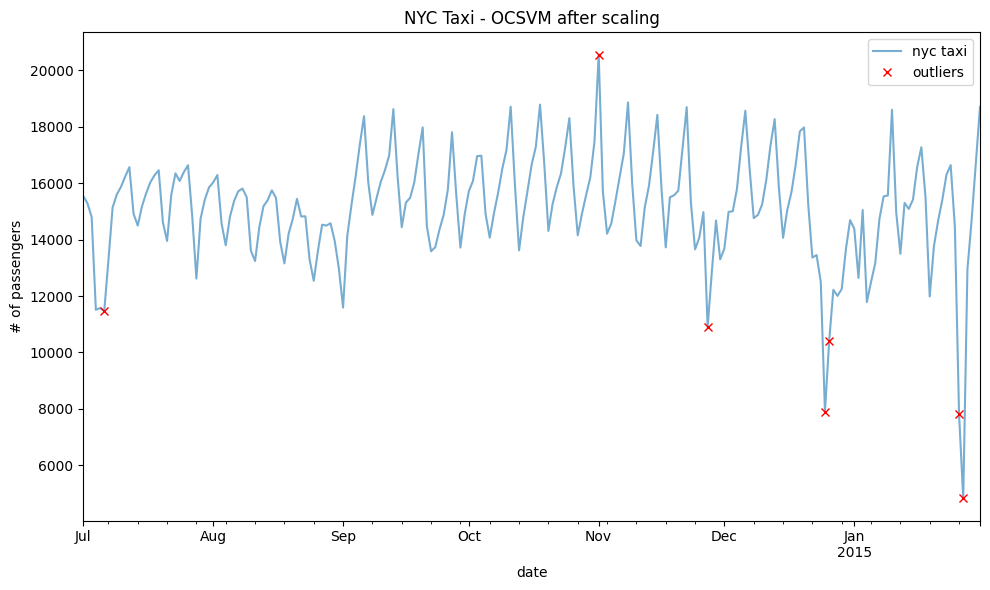

In [101]:
plot_outliers(ocsvm_outliers_sc, tx, 'OCSVM after scaling')

## There is more

In [102]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    ocsvm = OCSVM(contamination=0.03, 
                  kernel=kernel)
    ocsvm.fit(scaled)
    ocsvm_pred_sc = pd.Series(ocsvm.predict(scaled), 
                              index=tx.index, 
                              name=kernel)
    ocsvm_outliers_sc = ocsvm_pred_sc[ocsvm_pred_sc == 1]
    ocsvm_outliers_sc = tx.loc[ocsvm_outliers_sc.index]
    print(f"Outliers using {kernel} kerenl: \n{ocsvm_outliers_sc}")
    #plot_outliers(ocsvm_outliers_sc, tx, f"OCSVM using {kernel} kernel")

Outliers using linear kerenl: 
                   value
timestamp               
2014-09-13  18617.729167
2014-10-11  18706.416667
2014-10-18  18778.958333
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-11-22  18688.062500
2015-01-31  18702.479167
Outliers using poly kerenl: 
                   value
timestamp               
2014-07-04  11511.770833
2014-07-06  11464.270833
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
Outliers using rbf kerenl: 
                   value
timestamp               
2014-07-06  11464.270833
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
Outliers using sigmoid kerenl: 
                   value
timestamp               
2014-07-04  11511.770833
2014-07-06  11464.270833
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-

# Detecting outliers using ensemble methods algorithms (PyOD)

In [103]:
from pyod.models.iforest import IForest

In [104]:
iforest = IForest(contamination=0.03,
                 n_estimators=100,
                 bootstrap=False,
                 random_state=45)
iforest.fit(tx)

IForest(behaviour='old', bootstrap=False, contamination=0.03,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=45, verbose=0)

In [105]:
iforest_pred = pd.Series(iforest.predict(tx), 
                      index=tx.index)

/Users/tarekatwan/Repos/MyWork/Teach/repos/advanced_machine_learning/dev1/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [106]:
print('Number of IForest outliers = ', iforest_pred.sum())

Number of IForest outliers =  7


In [107]:
# extract the outlier values and dates from iforest_pred
iforest_outliers = iforest_pred[iforest_pred == 1]
iforest_outliers = tx.loc[iforest_outliers.index] 
print(iforest_outliers)

                   value
timestamp               
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


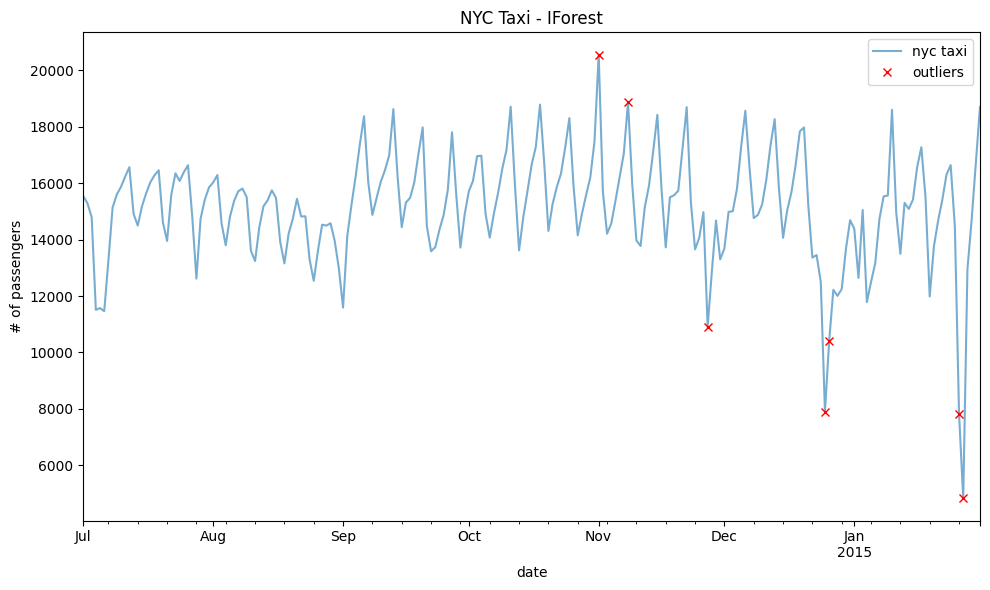

In [108]:
plot_outliers(iforest_outliers, tx, 'IForest')

## There is more

In [109]:
import pandas as pd
from pyod.models.dif import DIF
import warnings
warnings.filterwarnings('ignore')

# Initialize and fit the DIF model 
dif = DIF(contamination=0.03, n_estimators=100)
dif.fit(tx)

# Get outliers
dif_scores = dif.decision_scores_
dif_threshold = np.quantile(dif_scores, 0.97)  # Adjust percentile as needed
dif_outliers = tx[dif_scores > dif_threshold]
print(dif_outliers)

please install torch first


ModuleNotFoundError: No module named 'torch'

In [110]:
plot_outliers(dif_outliers, tx, 'DIF')

NameError: name 'dif_outliers' is not defined

# Detecting outliers using deep learning-based algorithms (PyOD)

In [278]:
# !pip install torch
# !pip install tqdm

In [112]:
from pyod.models.auto_encoder import AutoEncoder

In [113]:
# lr: Learning rate for optimization
# epoch_num: Number of training iterations
# batch_size: Number of samples per training batch
auto_encoder = AutoEncoder(contamination=0.03,
                           lr=0.001,
                           epoch_num=10,
                           batch_size=32)
auto_encoder.fit(tx)

Training: 100%|██████████| 10/10 [00:00<00:00, 58.08it/s]


In [114]:
ae_predicted = pd.Series(auto_encoder.predict(tx), 
                      index=tx.index)

In [115]:
print('Number of AutoEncoder outliers = ', ae_predicted.sum())

Number of AutoEncoder outliers =  7


In [116]:
# extract the outlier values and dates from ae_predicted
ae_outliers = ae_predicted[ae_predicted == 1]
ae_outliers = tx.loc[ae_outliers.index] 
print(ae_outliers)

                   value
timestamp               
2014-09-23  13729.354167
2014-09-29  13715.166667
2014-11-17  13722.791667
2014-11-24  13652.625000
2014-12-01  13683.625000
2014-12-30  13659.687500
2015-01-20  13759.416667


In [117]:
ae_scores = pd.Series(auto_encoder.decision_scores_, 
                      index=tx.index)

threshold = auto_encoder.threshold_
# or you can do it using quantile 
threshold = ae_scores.quantile(0.97)

In [118]:
ae_outliers =tx[ae_scores > ae_scores.quantile(0.97)]
print(ae_outliers)

                   value
timestamp               
2014-09-23  13729.354167
2014-09-29  13715.166667
2014-11-17  13722.791667
2014-11-24  13652.625000
2014-12-01  13683.625000
2014-12-30  13659.687500
2015-01-20  13759.416667


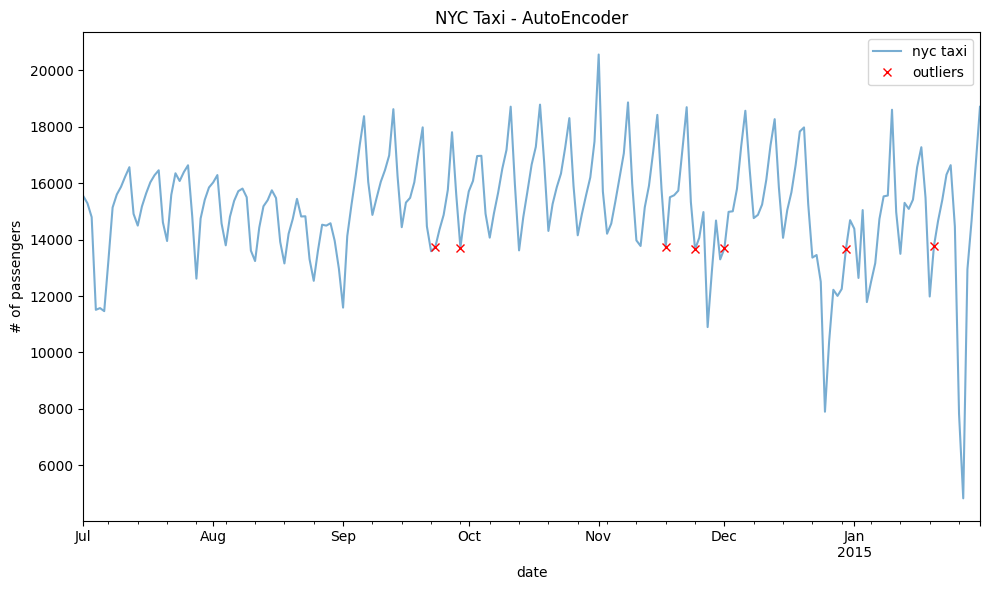

In [119]:
plot_outliers(ae_outliers, tx, 'AutoEncoder')

In [120]:
%%time
auto_encoder = AutoEncoder(contamination=0.03,
                           lr=0.001,
                           epoch_num=1000,
                           batch_size=32)
auto_encoder.fit(tx)
ae_predicted = pd.Series(auto_encoder.predict(tx), 
                      index=tx.index)
# extract the outlier values and dates from ae_predicted
ae_outliers = ae_predicted[ae_predicted == 1]
ae_outliers = tx.loc[ae_outliers.index] 
print(ae_outliers)

Training: 100%|██████████| 1000/1000 [00:14<00:00, 71.41it/s]

                   value
timestamp               
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
CPU times: user 9.82 s, sys: 11.3 s, total: 21.1 s
Wall time: 14 s


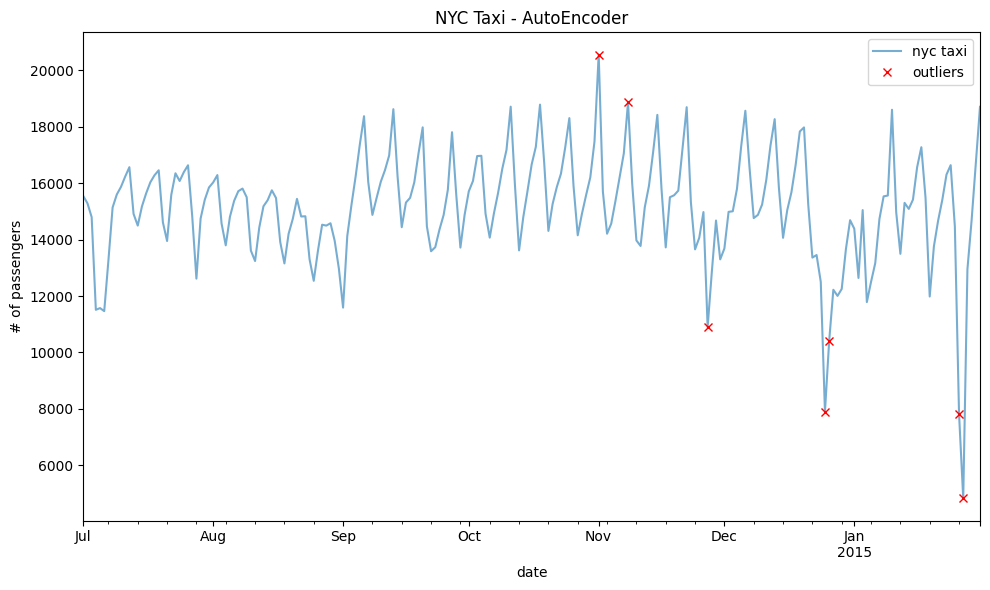

In [121]:
plot_outliers(ae_outliers, tx, 'AutoEncoder')

## There is more

In [122]:
from pyod.models.vae import VAE

# lr: Learning rate for optimization
# epoch_num: Number of training iterations
# batch_size: Number of samples per training batch
vae = VAE(contamination=0.03,
                           lr=0.001,
                           epoch_num=1000,
                           batch_size=32)
vae.fit(tx)

vae_predicted = pd.Series(vae.predict(tx), 
                      index=tx.index)
# extract the outlier values and dates from ae_predicted
vae_outliers = vae_predicted[vae_predicted == 1]
vae_outliers = tx.loc[vae_outliers.index] 
print(vae_outliers)

Training: 100%|██████████| 1000/1000 [00:10<00:00, 98.77it/s]

                   value
timestamp               
2014-07-04  11511.770833
2014-07-06  11464.270833
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
